## Apache Spark 
@Geo_Inca  

Se ha convertido en una de las herramientas más utilizadas para el **Aprendizaje Automático**.  En este ejemplo vamos a usar Apache Spark’s spark.ml Linear Regression para predecir el precio de las viviendas en Boston; nuestros datos son de Kaggle: **Precios de la vivienda en los suburios de Boston".
    

In [1]:

from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import six
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col,sum

In [2]:
spark = SparkSession.builder.appName('LinearRegresion').getOrCreate()

#### Los datos de cada vivienda tienen los siguientes campos:
**CRIM** - tasa de delincuencia per cápita por ciudad.  
**ZN**: proporción de tierra residencial zonificada para lotes de más de 25,000 pies cuadrados.  
**INDUS** - proporción de acres de negocios no minoristas por ciudad.  
**CHAS** - Variable ficticia del río Charles (= 1 si el trecho delimita el río; 0 en caso contrario).  
**NOX** - concentración de óxidos de nitrógeno (partes por 10 millones).  
**RM** - número promedio de habitaciones por vivienda.  
**AGE**: proporción de unidades ocupadas por el propietario construidas antes de 1940.  
**DIS**: media ponderada de las distancias a cinco centros de empleo de Boston.  
**RAD** - Índice de accesibilidad a autopistas radiales.  
**TAX**: tasa de impuesto a la propiedad de valor total por $ 10,000.  
**PTRATIO** - Proporción alumno-profesor por ciudad.  
**BLACK** - 1000 (Bk - 0,63) ² donde Bk es la proporción de negros por ciudad.  
**LSTAT** - estado más bajo de la población (porcentaje).  
**medv**: valor medio de las viviendas ocupadas por sus propietarios en miles de dólares. Esta es la variable objetivo.


In [3]:
schema = StructType([
StructField("ID",IntegerType()),
StructField("crim",DoubleType()),
StructField("zn",DoubleType()),
StructField("indus",DoubleType()),
StructField("chas",IntegerType()),
StructField("nox",DoubleType()),
StructField("rm",DoubleType()),
StructField("age",DoubleType()),
StructField("dis",DoubleType()),
StructField("rad",IntegerType()),
StructField("tax",IntegerType()),
StructField("ptratio",DoubleType()),
StructField("black",DoubleType()),
StructField("lstat",DoubleType()),
StructField("medv",DoubleType())    
])

### Cargar los datos

In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark import SparkContext
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('train.csv')
df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

### Exploración de los Datos.  
Imprimir el esquema de los datos


In [5]:
df.cache()
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



### Analíticas Descriptivas
Número de datos, Valores Nulos, Media, Promedio, Mínimo y Máximo de cada uno de los datos

In [6]:
# Encabezado
df_select1 = df.columns[1:]
df_select2 = df.columns[1:-1]

In [7]:
# Valores Null (missing values)
df_null = df.select(*(F.sum(F.col(c).isNull().cast("Double")).alias(c) for c in df.columns)).toPandas()
df_null

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


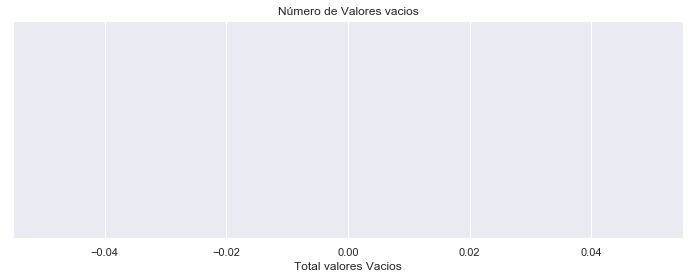

In [8]:
missing_df = df.select([c for c in df_select1]).toPandas().isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,4))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel('Total valores Vacios')
ax.set_title('Número de Valores vacios')
plt.show()
# en este dataframe  se han tratado en origen  los datos vacios

In [9]:
# Valores Nulos, Media, Promedio, Mínimo y Máximo 
df.describe().toPandas().transpose()
#df_describe = df.select([c for c in df_select1]).describe().toPandas().transpose()
#df_describe

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,333,250.95195195195194,147.8594378018597,1,506
crim,333,3.3603414714714708,7.352271836781104,0.00632,73.5341
zn,333,10.68918918918919,22.674761796618217,0.0,100.0
indus,333,11.29348348348346,6.998123104477312,0.74,27.74
chas,333,0.06006006006006006,0.2379556428164483,0,1
nox,333,0.557144144144145,0.11495450830289312,0.385,0.871
rm,333,6.265618618618616,0.7039515757334471,3.561,8.725
age,333,68.22642642642641,28.13334360562338,6.0,100.0
dis,333,3.7099336336336335,1.9811230514407001,1.1296,10.7103


In [10]:
# Dispersión de los datos
for col in df_select1:
    col_count = df.select(col).distinct().count()
    print("variable {0} , total {1}".format(col, col_count))

variable crim , total 332
variable zn , total 25
variable indus , total 68
variable chas , total 2
variable nox , total 77
variable rm , total 308
variable age , total 260
variable dis , total 295
variable rad , total 9
variable tax , total 59
variable ptratio , total 42
variable black , total 237
variable lstat , total 310
variable medv , total 192


In [11]:
# Muestreo del data set 
df_dataset = df.limit(10)
df_dataset.toPandas()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
5,11,0.22489,12.5,7.87,0,0.524,6.377,94.3,6.3467,5,311,15.2,392.52,20.45,15.0
6,12,0.11747,12.5,7.87,0,0.524,6.009,82.9,6.2267,5,311,15.2,396.90,13.27,18.9
7,13,0.09378,12.5,7.87,0,0.524,5.889,39.0,5.4509,5,311,15.2,390.50,15.71,21.7
8,14,0.62976,0.0,8.14,0,0.538,5.949,61.8,4.7075,4,307,21.0,396.90,8.26,20.4
9,15,0.63796,0.0,8.14,0,0.538,6.096,84.5,4.4619,4,307,21.0,380.02,10.26,18.2


In [12]:
def plot_model(lables, alg_name, plot_index):
    ax = fig.add_subplot(3,2,plot_index) 
    color_code = {'anomaly':'red', 'normal':'green'}
    colors = [color_code[x] for x in labels]
    ax.scatter(X.iloc[:,0], X.iloc[:,1], color=colors, marker='.', label='red = anomaly')
    ax.legend(loc="lower right")
    leg = plt.gca().get_legend()
    #leg.legendHandles[0].set_color('red')
    ax.set_title(alg_name)

## Gráfico de  Correlación
Como era de suponer a más número de habitaciones **rm** el valor de la vivienda sube, la tasa de crimen tienen una relación negativa, si disminuye la tasa de crimen el valor sube

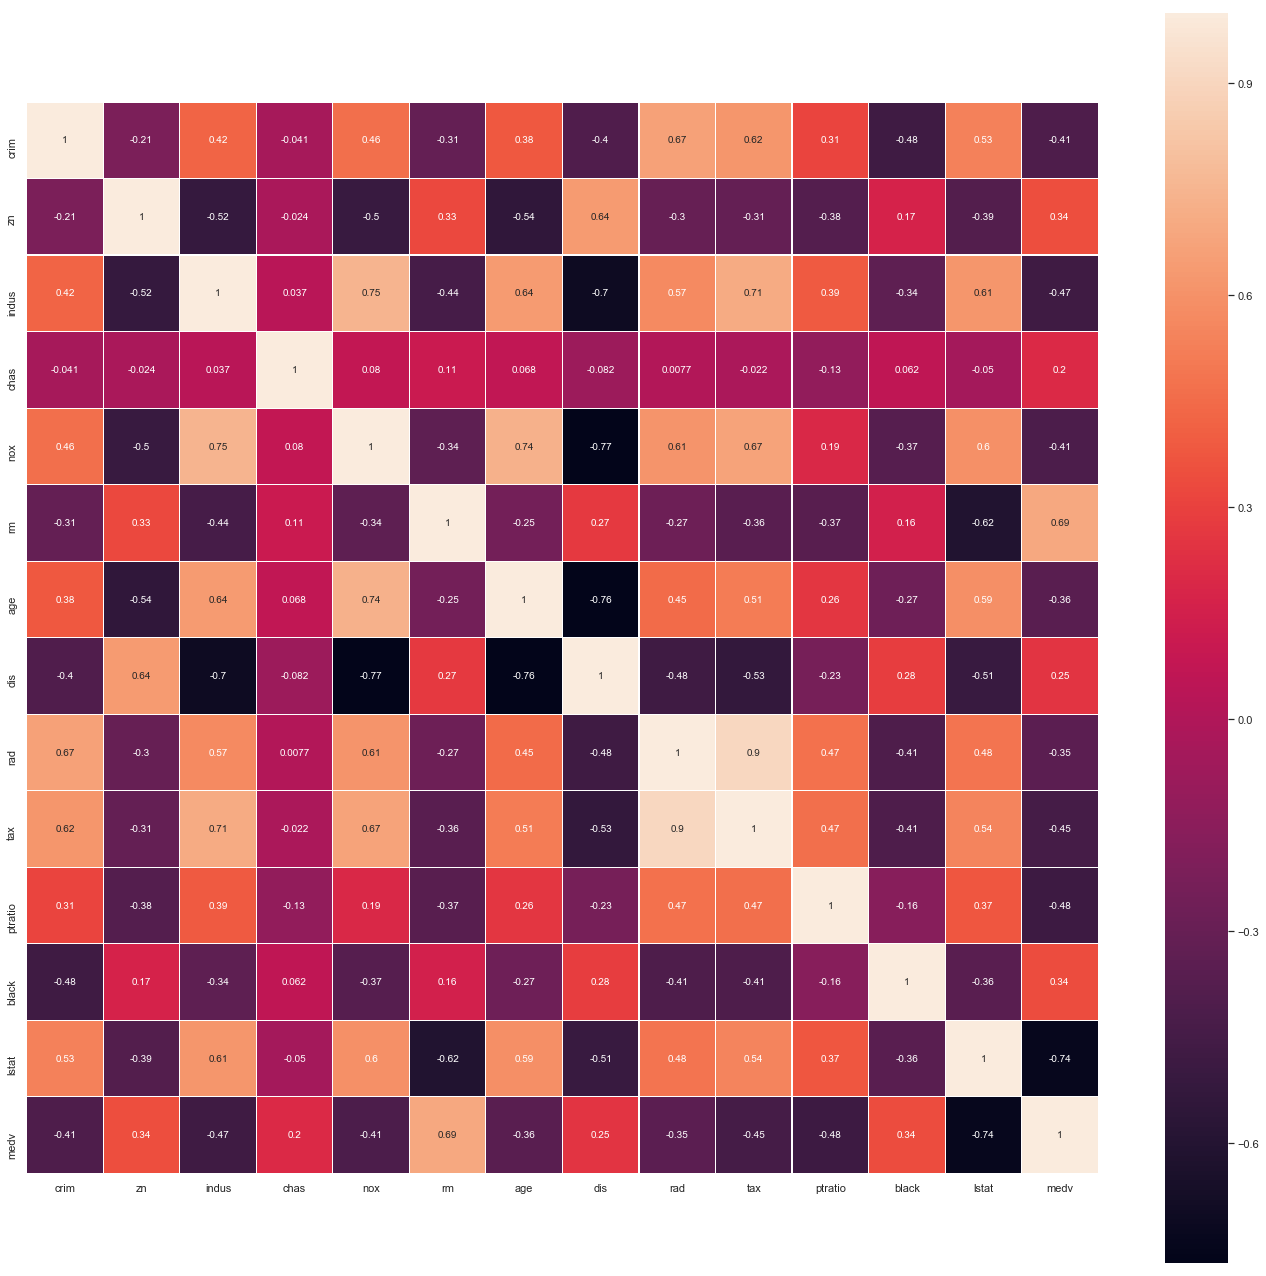

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure(figsize=(24,23))
sns.heatmap(df.select([c for c in df_select1]).toPandas().corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)
plt.show()
plt.gcf().clear()

## Gráfico de la Distribución
según la relación de los datos, el predictor **chas** no aporta información relevante en este conjunto de datos.

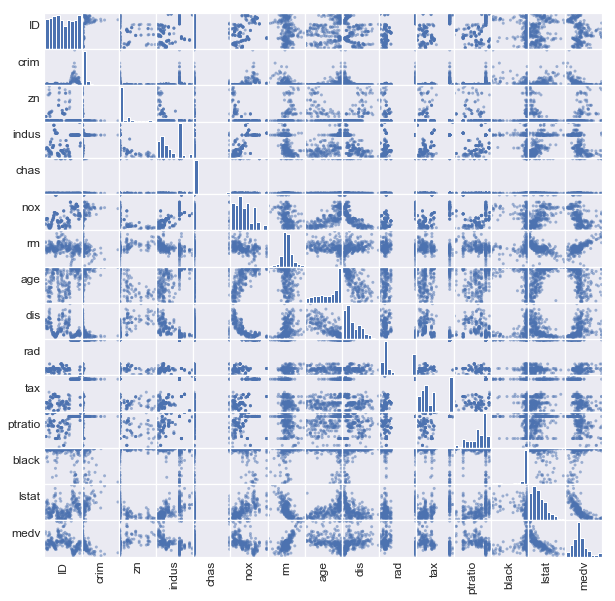

In [14]:
import pandas as pd
from pandas.plotting import scatter_matrix
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [15]:
import six
for i in df.columns:
    if not( isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlación de medv en comparación a: ", i, df.stat.corr('medv',i))
        
# el predictor chas tiene menos correlacion que el ID.

Correlación de medv en comparación a:  ID -0.22169418651611697
Correlación de medv en comparación a:  crim -0.4074543235732598
Correlación de medv en comparación a:  zn 0.34484197569664277
Correlación de medv en comparación a:  indus -0.47393197065920345
Correlación de medv en comparación a:  chas 0.20438998859918733
Correlación de medv en comparación a:  nox -0.4130541519920783
Correlación de medv en comparación a:  rm 0.6895980892872156
Correlación de medv en comparación a:  age -0.35888827406190227
Correlación de medv en comparación a:  dis 0.24942226829396397
Correlación de medv en comparación a:  rad -0.3522508242456341
Correlación de medv en comparación a:  tax -0.44807769440070433
Correlación de medv en comparación a:  ptratio -0.48137595552491735
Correlación de medv en comparación a:  black 0.33665955532155767
Correlación de medv en comparación a:  lstat -0.7386000348786346
Correlación de medv en comparación a:  medv 1.0


## Vectorización de los datos
Agrupamos el dataframe  por una parte las columnas que usararemos para predecir *predictores* en este caso lo llamaremos "features" y como variable a predecir *medv* 

In [16]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'], outputCol = 'features')
 
v_df = assembler.transform(df)
v_df = v_df.select(['features', 'medv'])#
v_df.show(3)


+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.03237,0.0,2.18...|33.4|
+--------------------+----+
only showing top 3 rows



separamos los datos en 2 dataframes, esta división es al azar: train_df y test_df que los usararemos como datos de entrenamiento y datos de control.


In [17]:
splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

## Linear Regression
Los modelos de regresión lineal son los más utilizados a la hora de predecir los valores de una vriable cuantitativa a partir de los valores de otra variable explicativa también  cuantitativa.
Regresion lineal multiple permite considerar más de una variable explicativa.


In [18]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0014358598252088085,0.0,4.74242438138695,-1.3900950497474391,4.3400813606137065,-0.004011764490497107,-0.5133972380003444,0.012936052064401208,0.0,-0.5817943819306785,0.0056800535031283905,-0.6489997024809576]
Intercept: 14.787418688084411


In [19]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.764000
r2: 0.723238


In [20]:
train_df.describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               230|
|   mean|22.803913043478275|
| stddev| 9.075377331229591|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [21]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="medv",metricName="r2")
print("R cuadrado (R2) de los datos de test = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|29.546977460646264|32.2|[0.00906,90.0,2.9...|
|26.318963583968554|33.0|[0.01951,17.5,1.3...|
| 38.30667066749551|50.0|[0.02009,95.0,2.6...|
|26.358121676808118|16.5|[0.02498,0.0,1.89...|
|25.128990947560172|21.6|[0.02731,0.0,7.07...|
+------------------+----+--------------------+
only showing top 5 rows

R cuadrado (R2) de los datos de test = 0.651353


### R2
Tener un R2 de 0.73 indica que nuestro modelo puede explicar un 73% la variabilidad de **medv**

In [22]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) de los datos de  test = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) de los datos de  test = 5.54292


In [23]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.49999999999999956, 0.43286642524939023, 0.24622972926177925, 0.2194029662382702, 0.18204059945586812, 0.17795586211908868, 0.1768252112945027, 0.1756174596654961, 0.17434873167278017, 0.1739022327398133, 0.1737262739545478]
+-------------------+
|          residuals|
+-------------------+
| -6.373942951568857|
| -4.464911275534192|
|  1.186978423178612|
|   5.35720467361886|
|  2.557141160737288|
| 1.1470063399201607|
|-0.8434939859605315|
| -2.685391609978435|
| 7.3364593865378325|
| 2.1118008247362745|
|-2.7389708809055584|
| 0.5139145759957131|
|-0.9526729202698796|
| 0.5973086781092292|
|-3.6053564497771546|
| 1.9018904015392017|
|-1.8248349719257355|
| 1.5678439699850735|
| 2.6806974302605937|
|-2.1874063691607617|
+-------------------+
only showing top 20 rows



### Predecir
Un test entre el valor real y el valor predicho por nuestro modelo

In [24]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|29.546977460646264|32.2|[0.00906,90.0,2.9...|
|26.318963583968554|33.0|[0.01951,17.5,1.3...|
| 38.30667066749551|50.0|[0.02009,95.0,2.6...|
|26.358121676808118|16.5|[0.02498,0.0,1.89...|
|25.128990947560172|21.6|[0.02731,0.0,7.07...|
|26.655428473516444|26.6|[0.02899,40.0,1.2...|
| 20.87873015169328|19.5|[0.03427,0.0,5.19...|
|26.587578151664545|24.1|[0.03445,82.5,2.0...|
|28.470329601689535|27.9|[0.03615,80.0,4.9...|
| 24.13075405584544|20.7|[0.03738,0.0,5.19...|
|24.082275188823644|19.8|[0.04544,0.0,3.24...|
|26.483678919725044|23.3|[0.0456,0.0,13.89...|
|24.532398556866575|23.9|[0.05059,0.0,4.49...|
| 26.75369751145871|28.4|[0.05479,33.0,2.1...|
| 35.26371730699242|50.0|[0.05602,0.0,2.46...|
|27.700571543177933|26.6|[0.05735,0.0,4.49...|
|22.375336083763838|22.0|[0.05789,12.5,6.0...|
| 40.83188204993431|46.0|[0.06129,20.0,3.3...|
|21.805506630

## Decision tree regression
ahora vamos a probrar otro modelo de regresión a nuestros datos,

In [25]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.74671


In [26]:
dt_model.featureImportances

SparseVector(13, {0: 0.0627, 4: 0.0354, 5: 0.2302, 7: 0.0694, 10: 0.0186, 11: 0.0036, 12: 0.5801})

In [27]:
df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

## Gradient-boosted tree regression

In [28]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 33.86518624494589|32.2|[0.00906,90.0,2.9...|
| 34.85489880386723|33.0|[0.01951,17.5,1.3...|
|  50.3779100292619|50.0|[0.02009,95.0,2.6...|
|24.432615681427443|16.5|[0.02498,0.0,1.89...|
| 23.23803639153213|21.6|[0.02731,0.0,7.07...|
+------------------+----+--------------------+
only showing top 5 rows



In [29]:
gbt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.55187
